# TimeSeries Prediction with RNN

In [1]:
import pandas
import matplotlib.pyplot as plt
%matplotlib inline

## 미국 국제선 탑승객 수 (1949/01 ~ 1960/12, 단위 천명)

In [2]:
df = pandas.read_csv('data/international-airline-passengers.csv', usecols=[1], engine='python')
df.head()

,passengers
0,112
1,118
2,132
3,129
4,121


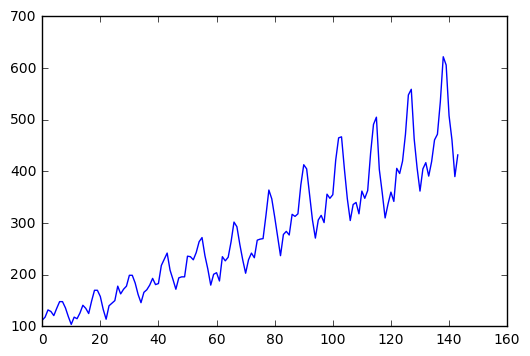

In [3]:
plt.plot(df)
plt.show()

In [4]:
import numpy
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


### 데이터 준비

DataFrame 을 array로 변경

In [5]:
dataset = df.values
dataset = dataset.astype('float32')
dataset[:10]

array([[ 112.],
       [ 118.],
       [ 132.],
       [ 129.],
       [ 121.],
       [ 135.],
       [ 148.],
       [ 148.],
       [ 136.],
       [ 119.]], dtype=float32)

0에서 1 사이의 값으로 normalize

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [7]:
dataset[:10]

array([[ 0.01544401],
       [ 0.02702703],
       [ 0.05405405],
       [ 0.04826255],
       [ 0.03281853],
       [ 0.05984557],
       [ 0.08494207],
       [ 0.08494207],
       [ 0.06177607],
       [ 0.02895753]], dtype=float32)

트레이닝셋, 테스트셋 분리

In [8]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print(len(train), len(test))

100 44


1열의 데이터를 이번 달 승객수(X), 다음 달 승객(Y) 형태의 2열로 변환

```bash
X		Y
112		118
118		132
132		129
129		121
121		135
```

In [9]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [10]:
# X = t and Y = t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [11]:
trainX.shape

(98, 1)

In [12]:
testX.shape

(42, 1)

RNN 입력 데이터 형태로 변환 [samples, time steps, features]

In [13]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
trainX.shape

(98, 1, 1)

## RNN 학습 및 검증

In [15]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=1)

Epoch 1/20
98/98 [==============================] - 0s - loss: 0.0471     
Epoch 2/20
98/98 [==============================] - 0s - loss: 0.0218     
Epoch 3/20
98/98 [==============================] - 0s - loss: 0.0166     
Epoch 4/20
98/98 [==============================] - 0s - loss: 0.0152     
Epoch 5/20
98/98 [==============================] - 0s - loss: 0.0142     
Epoch 6/20
98/98 [==============================] - 0s - loss: 0.0132     
Epoch 7/20
98/98 [==============================] - 0s - loss: 0.0122     
Epoch 8/20
98/98 [==============================] - 0s - loss: 0.0112     
Epoch 9/20
98/98 [==============================] - 0s - loss: 0.0103     
Epoch 10/20
98/98 [==============================] - 0s - loss: 0.0092     
Epoch 11/20
98/98 [==============================] - 0s - loss: 0.0082     
Epoch 12/20
98/98 [==============================] - 0s - loss: 0.0072     
Epoch 13/20
98/98 [==============================] - 0s - loss: 0.0062     
Epoch 14/20
98/98 [==

### 예측

In [17]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

위에서 예측한 값은 0에서 1사이의 값이므로 원래 단위로 변환 필요.

In [18]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

### RMSE로 성능 평가

In [19]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f' % (testScore))

Train Score: 24.63
Test Score: 50.98


그래프로 확인

* 파란색 - 원본 데이터
* 초록색 - 트레이닝셋 예측 
* 빨간색 - 테스트셋 예측

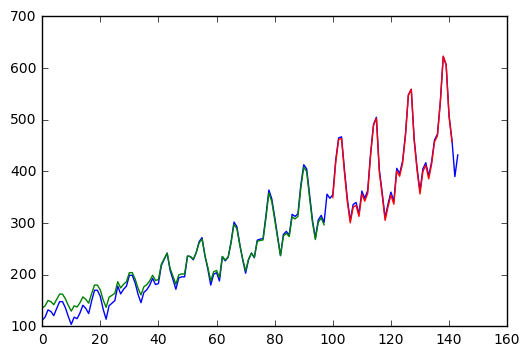

In [20]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[0:len(trainPredict), :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+2:len(dataset)-2, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()